# Sentiment Classification & How To "Frame Problems" for a Neural Network

inspired by Andrew Trask
- **Blog**: http://iamtrask.github.io

It's a simplified version of Andrew Trask notebook in kotlin

In [1]:
import java.io.File
val reviews = File("../../data/sentiment-classification/reviews.txt").readLines()
val labels = File("../../data/sentiment-classification/labels.txt").readLines()

In [2]:
fun pretty_print_review_and_label(i: Int) { println(labels[i] + "\t:\t" + reviews[i].take(80) + "...") }
println("labels.txt\t: \treviews.txt")
pretty_print_review_and_label(2137)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(4998)

labels.txt	: 	reviews.txt
negative	:	this movie is terrible but it has some good effects .  ...
positive	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
negative	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
positive	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
negative	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
positive	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


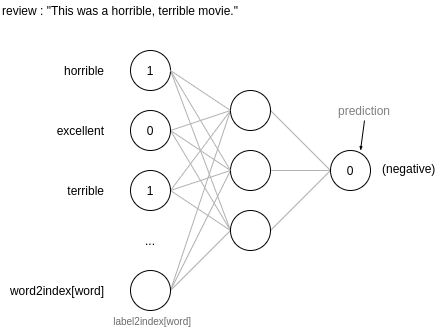

# Transforming Text into Numbers
In this example, each node of the input layer represents the presence of a word<br>
<br>
So the full vocabulary in all reviews will be equal to the size of the input layer<br>
<br>
Creating a set named `vocab` that contains every word in the vocabulary.<br>
(to construct word2index and label2index map)

In [3]:
val vocab = mutableSetOf<String>()
for(review in reviews) {
    for (word in review.split(" ")) {
        vocab.add(word)
    }
}
vocab.size

74074

### Importing deeplearning4j (and nd4j) librairies

In [4]:
%use deeplearning4j-cuda
@file:DependsOn("../../lib/nd4k.jar")

Adding some sugar to nd4j to make symbolic representation (like + or *) available 

In [5]:
import org.nd4j.linalg.api.ndarray.INDArray
import org.nd4j.linalg.factory.Nd4j
import org.nd4j.linalg.ops.transforms.Transforms
import org.nd4j.linalg.ops.transforms.Transforms.exp
import java.io.File
import kotlin.collections.set
import kotlin.math.*

import org.nd4k.*
// // a + b    &&    a += b
// operator fun INDArray.plus(other: INDArray): INDArray { return this.add(other) }
// operator fun INDArray.plus(other: Number): INDArray { return this.add(other) }
// operator fun Number.plus(other: INDArray): INDArray { return other.add(this) }

// // -a
// operator fun INDArray.unaryMinus(): INDArray { return this.mul(-1.0) }

// // a - b    &&    a -= b
// operator fun INDArray.minus(other: INDArray): INDArray { return this.sub(other) }
// operator fun INDArray.minus(other: Number): INDArray { return this.sub(other) }
// operator fun Number.minus(other: INDArray): INDArray { return this + -other }

// // a * b
// operator fun INDArray.times(other: INDArray): INDArray { return this.mul(other) }
// operator fun INDArray.times(other: Number): INDArray { return this.mul(other) }
// operator fun Number.times(other: INDArray): INDArray { return other * this }

// // a / b
// operator fun INDArray.div(other: INDArray): INDArray { return this.div(other) }
// // operator fun INDArray.div(other: Number): INDArray // already define in INDArray
// operator fun Number.div(other: INDArray): INDArray { return this * other.rdiv(1) }

// // a.T()
// fun INDArray.T(): INDArray { return this.transpose() }

// // a.dot(b) ~numpy style
// fun INDArray.dot(other: INDArray): INDArray { return this.mmul(other) }

// // exp(a)
// fun exp(a: INDArray): INDArray { return exp(a, false) }

In [6]:
var sigmoid = { x: INDArray -> 1.0 / (1.0 + exp(-x, false)) }
var sigmoid_derivative = { x: INDArray ->
    val sigmoidValue =  sigmoid(x)
    ( 1 - sigmoidValue ) * sigmoidValue
}

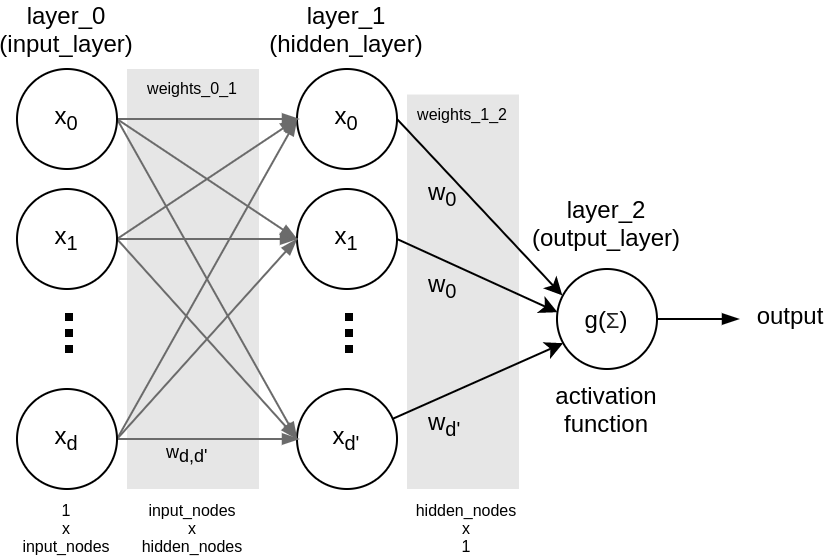

In [7]:
class SentimentNetwork(val vocab: Set<String>,
                       val activationFunction: (INDArray) -> INDArray,
                       val derivativeFunction: (INDArray) -> INDArray,
                       val hidden_nodes: Int = 10,
                       val output_nodes: Int = 1,
                       val learning_rate: Double = 0.1,
                       val printIterations: Int = 2500) {

    val input_nodes = this.vocab.size.toInt()

    var weights_0_1 = Nd4j.zeros(input_nodes, hidden_nodes)
    var weights_1_2 = Nd4j.randn(hidden_nodes.toLong(), output_nodes.toLong())

    val word2index = mutableMapOf<String, Int>()
    val label2index = mutableMapOf<String, Int>()

    init {
        preProcessData()
    }

    fun preProcessData() {
        for ((i, word) in vocab.withIndex())
            word2index[word] = i

        for ((i, word) in vocab.withIndex())
            label2index[word] = i
    }
}

In [8]:
fun SentimentNetwork.getInputLayer(review: String): INDArray {
    val arrayOfZeros = FloatArray(input_nodes.toInt())
    for (word in review.split(" ")) {
        if (word in word2index.keys) {
            arrayOfZeros[word2index[word]!!] = 1f
        }
    }
    return Nd4j.create(arrayOfZeros, intArrayOf(1, input_nodes.toInt()))
}

In [9]:
fun SentimentNetwork.getTargetForLabel(label: String): Double {
    return when (label) {
        "positive" -> 1.0
        else -> 0.0
    }
}

In [10]:
fun SentimentNetwork.round(dbl: Number, decimals: Int = 2): Double {
    var multiplier = 10.0.pow(decimals)
    return Math.round(dbl.toDouble() * multiplier) / multiplier
}

fun SentimentNetwork.printDebugInfo(iteration: Int,
                                    reviewed: Int,
                                    correct_so_far: Int,
                                    printIterations: Int = 2500) {
    if (iteration % printIterations == 0 || iteration == reviewed) {
        val progress = round(100 * iteration / (reviewed))
        val training_accuracy = round(correct_so_far * 100 / iteration.toDouble())

        println("Progress:" + progress.toString().padStart(6) + "%"
                + " #Correct:" + correct_so_far.toString().padStart(6)
                + " #Iteration:" + iteration.toString().padStart(6)
                + " Accuracy:" + training_accuracy.toString().padStart(4) + "%")
    }
}

In [11]:
fun SentimentNetwork.isPredictionCorrect(output: Float, label: String): Boolean {
    if (output >= 0.5 && label == "positive")
        return true
    else if (output < 0.5 && label == "negative")
        return true
    return false
}

In [12]:
fun SentimentNetwork.train(training_reviews: List<String>, training_labels: List<String>) {
    var correct_so_far = 0

    for ((i, review) in training_reviews.withIndex()) {
        val layer_0 = getInputLayer(review)

        // forward
        val layer_1 = layer_0.dot(weights_0_1)
        val layer_2 = activationFunction(layer_1.dot(weights_1_2))

        // back propagation
        val label = training_labels[i]
        val layer_2_error = layer_2 - getTargetForLabel(label)
        val layer_2_delta = layer_2_error * derivativeFunction(layer_2)

        val layer_1_error = layer_2_delta.dot(weights_1_2.T())
        val layer_1_delta = layer_1_error

        weights_1_2 -= layer_1.T().dot(layer_2_delta) * learning_rate
        weights_0_1 -= layer_0.T().dot(layer_1_delta) * learning_rate

        val output = layer_2.getFloat(0)
        if (isPredictionCorrect(output, label)) { correct_so_far++ }
        printDebugInfo(i + 1 , training_reviews.size, correct_so_far, printIterations)
    }
}

In [13]:
val training_reviews = reviews.take(25000 - 1000)
val training_labels = labels.take(25000 - 1000)
val test_reviews = reviews.takeLast(1000)
val test_labels = labels.takeLast(1000)

var mlp = SentimentNetwork(vocab, sigmoid, sigmoid_derivative, learning_rate=0.1)

In [14]:
mlp.train(training_reviews,training_labels)

Progress:  10.0% #Correct:  1943 #Iteration:  2500 Accuracy:77.72%
Progress:  20.0% #Correct:  3998 #Iteration:  5000 Accuracy:79.96%
Progress:  31.0% #Correct:  6122 #Iteration:  7500 Accuracy:81.63%
Progress:  41.0% #Correct:  8288 #Iteration: 10000 Accuracy:82.88%
Progress:  52.0% #Correct: 10434 #Iteration: 12500 Accuracy:83.47%
Progress:  62.0% #Correct: 12574 #Iteration: 15000 Accuracy:83.83%
Progress:  72.0% #Correct: 14691 #Iteration: 17500 Accuracy:83.95%
Progress:  83.0% #Correct: 16868 #Iteration: 20000 Accuracy:84.34%
Progress:  93.0% #Correct: 19053 #Iteration: 22500 Accuracy:84.68%
Progress: 100.0% #Correct: 20378 #Iteration: 24000 Accuracy:84.91%


In [15]:
fun SentimentNetwork.run(review: String): String {
    val layer_0 = getInputLayer(review)

    // forward
    val layer_1 = layer_0.dot(weights_0_1)
    val layer_2 = activationFunction(layer_1.dot(weights_1_2))
    val output = layer_2.getFloat(0)

    if (output >= 0.5)
        return "positive"
    else
        return "negative"
}

fun SentimentNetwork.test(test_reviews: List<String>, test_labels: List<String>) {
    var correct = 0
    for ((i, review) in test_reviews.withIndex()) {
        val label = test_labels[i]
        val pred = run(review)
        if(pred ==label){
            correct += 1
        }
        printDebugInfo(i + 1 , test_reviews.size, correct, printIterations)
    }
}

In [16]:
mlp.test(test_reviews,test_labels)

Progress: 100.0% #Correct:   855 #Iteration:  1000 Accuracy:85.5%
